# Analyse du jeu de données DVF - Appartements à Paris

L"objectif est d"analyser les transactions pour les **appartements** situés à **Paris** entre 2017 et 2022:
- Filtres statiques
- Modèles de régression
- Valeurs aberrantes
- Contribution des variables

On commencera par utiliser la base de données DVF. 

**TODO**
- Faire une combinaison trimestre/année (ex: "Q12018")

- **Ajouter les données de la Base Nationale des Bâtiments (exploration, puis modèles)**

- (Ajouter des variables externes (ex: pollution, transports en commun, bdd bâtiments))

- `nombre_pieces_principales` : dummy ou quanti ?

- Tester pipeline avec/sans preprocessing (`StandardScaler()` & `PCA()`)

- `optuna` 
    - optimisation hyperparams
    - utiliser `l_valeur_fonciere` en cible
    - objectif : test MAPE sur `valeur_fonciere`

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib.preprocessing import dvf

In [4]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
from rich import print

from multiprocessing import cpu_count

import seaborn as sns 
import matplotlib.pyplot as plt 

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet
) 

from sklearn.dummy import DummyRegressor

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error,
    mean_squared_error,  
    r2_score, 
    make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import sqlalchemy
from optuna import Trial, create_study

In [5]:
CPU_COUNT = cpu_count()
CPU_COUNT

8

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
DATA_DIR = "../data/"
ZIP_DIR = f"{DATA_DIR}dvf_cleaned.zip" 

## Data

In [8]:
df = dvf.concat_datasets_per_year(ZIP_DIR, geo_area="Paris", property_type="flats")

Processing 2022: 100%|██████████| 6/6 [03:17<00:00, 32.99s/it]


In [9]:
df.tail()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour
160752,2022-537265,2022-05-17,1,Vente,130000.0,20.0,NaN,RUE PIERRE LEROUX,7451,75007.0,75107,Paris 7e Arrondissement,75,NaN,NaN,75107000BG0031,NaN,NaN,12.0,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,11.0,1.0,NaN,NaN,NaN,NaN,NaN,2.319004,48.849079,0,11,Paris,Île-de-France,Paris,52512.0,2022,2,5,17
160753,2022-537266,2022-06-22,1,Vente,330375.0,10.0,NaN,RUE DU CHEVALERET,1990,75013.0,75113,Paris 13e Arrondissement,75,NaN,NaN,75113000CI0017,NaN,NaN,22.0,NaN,37.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.378447,48.825798,0,11,Paris,Île-de-France,Paris,181552.0,2022,2,6,22
160754,2022-537267,2022-06-29,1,Vente,2801244.0,3.0,NaN,VLA JOCELYN,4983,75016.0,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000EB0007,NaN,NaN,313.0,183.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,172.0,6.0,NaN,NaN,NaN,NaN,NaN,2.276055,48.865299,1,11,Paris,Île-de-France,Paris,165446.0,2022,2,6,29
160755,2022-537271,2022-06-21,1,Vente,423000.0,43.0,NaN,RUE DES FAVORITES,3536,75015.0,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,16.0,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,43.0,2.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454,1,11,Paris,Île-de-France,Paris,233484.0,2022,2,6,21
160756,2022-537272,2022-06-30,1,Vente,104650.0,50.0,NaN,RUE LEON FROT,5554,75011.0,75111,Paris 11e Arrondissement,75,NaN,NaN,75111000BS0234,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,15.0,1.0,NaN,NaN,NaN,NaN,NaN,2.386354,48.856079,0,11,Paris,Île-de-France,Paris,147017.0,2022,2,6,30


In [10]:
df.shape

(160757, 50)

In [11]:
n_unique_ids = df.id_mutation.unique().shape[0]
assert n_unique_ids == df.shape[0]

print(f"{n_unique_ids} transactions uniques pour les appartements à Paris")

160757 transactions uniques pour les appartements à Paris

### Sélection des variables

In [12]:
VARS = [
    "id_mutation", 
    "date_mutation", 
    "valeur_fonciere",
    "nom_commune",
    "longitude",
    "latitude", 
    "pop", 
    "annee", 
    "trimestre", 
    "mois", 
    "jour", 
    "dependance", 
    "surface_terrain", 
    "surface_reelle_bati", 
    "nombre_pieces_principales" 
]

df2 = df.loc[:, df.columns.isin(VARS)]

In [13]:
df2.shape

(160757, 15)

### Filtres statiques

**Objectif** : éliminer les biens ayant des caractéristiques aberrantes pouvant ajouter du bruit aux données

In [14]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.606820e+05,160756.000000,160756.000000,138.000000,160593.000000,160593.000000,160757.000000,160757.000000,160757.000000,160757.000000,160757.00000,160757.000000
mean,5.774656e+05,53.627877,2.411282,420.840580,2.340310,48.862293,0.278737,146606.664686,2019.485030,2.534154,6.62439,16.565157
std,8.807797e+05,39.868650,1.296799,576.248847,0.037832,0.019980,0.448379,61840.601802,1.526087,1.109350,3.39794,8.881552
min,1.500000e-01,1.000000,0.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.00000,1.000000
25%,2.550000e+05,28.000000,1.000000,144.250000,2.310880,48.845756,0.000000,91932.000000,2018.000000,2.000000,4.00000,9.000000
50%,4.100000e+05,43.000000,2.000000,210.500000,2.343348,48.862767,0.000000,165446.000000,2019.000000,3.000000,7.00000,17.000000
75%,6.775000e+05,68.000000,3.000000,453.250000,2.371079,48.879998,1.000000,195060.000000,2021.000000,4.000000,10.00000,25.000000
max,1.315000e+08,1500.000000,26.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.00000,31.000000


#### Nombre de pièces principales

Suppression des biens de + de 8 pièces principales et des biens ayant aucune pièce principale. 

In [15]:
df2.nombre_pieces_principales.value_counts()

2.0     54848
1.0     42061
3.0     36110
4.0     16434
5.0      7127
6.0      2551
7.0       969
8.0       299
0.0       196
9.0        75
10.0       47
11.0       17
12.0        6
13.0        3
17.0        2
16.0        2
20.0        2
22.0        1
21.0        1
19.0        1
23.0        1
26.0        1
14.0        1
15.0        1
Name: nombre_pieces_principales, dtype: int64

In [16]:
df2 = df2.loc[
    (df2.nombre_pieces_principales > 0) &
    (df2.nombre_pieces_principales <= 8),
    :
]

def encode_num_rooms(n: int) -> str: 
    """Description. Group properties with 6+ rooms into "6-8" category."""
    if n < 6: 
        return str(int(n))
    else: 
        return "6-8"

# convert to integer
df2["nombre_pieces_principales"] = df2["nombre_pieces_principales"].apply(encode_num_rooms)

In [17]:
df2.nombre_pieces_principales.value_counts()

2      54848
1      42061
3      36110
4      16434
5       7127
6-8     3819
Name: nombre_pieces_principales, dtype: int64

In [18]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.603240e+05,160399.000000,137.000000,160235.000000,160235.000000,160399.000000,160399.000000,160399.000000,160399.000000,160399.000000,160399.000000
mean,5.748149e+05,53.446156,419.934307,2.340339,48.862293,0.278674,146643.630484,2019.485203,2.534049,6.624243,16.564143
std,8.695325e+05,38.901960,578.264813,0.037830,0.019987,0.448348,61834.452756,1.526081,1.109335,3.397842,8.881882
min,1.500000e-01,1.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,2.550000e+05,28.000000,144.000000,2.310966,48.845753,0.000000,91932.000000,2018.000000,2.000000,4.000000,9.000000
50%,4.100000e+05,43.000000,210.000000,2.343348,48.862766,0.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,6.769000e+05,68.000000,442.000000,2.371096,48.880005,1.000000,195060.000000,2021.000000,4.000000,10.000000,25.000000
max,1.315000e+08,650.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


In [19]:
df2.loc[df2.nombre_pieces_principales == "6-8",: ].describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,3.818000e+03,3819.000000,9.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000,3819.000000
mean,2.210862e+06,187.706730,222.888889,2.310559,48.863778,0.540194,122775.075674,2019.507463,2.568473,6.732129,17.009427
std,1.520705e+06,58.435988,296.795150,0.031662,0.014603,0.498447,63198.709242,1.529570,1.106536,3.374673,8.847904
min,1.000000e+00,8.000000,33.000000,2.255896,48.820082,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,1.448500e+06,147.000000,88.000000,2.284334,48.853251,0.000000,52512.000000,2018.000000,2.000000,4.000000,10.000000
50%,2.020000e+06,178.000000,135.000000,2.304319,48.864034,1.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,2.739650e+06,218.000000,187.000000,2.330949,48.876606,1.000000,165446.000000,2021.000000,4.000000,10.000000,25.000000
max,2.150000e+07,650.000000,992.000000,2.407545,48.897606,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


#### Surface du bien

Au regard des graphiques suivants, il semble pertinent de garder les biens ayant une surface comprise entre 9m² et 250m².

D"après la [loi](https://www.service-public.fr/particuliers/vosdroits/F35977/1?idFicheParent=F34905#1), *un logement mis en location doit respecter une surface minimum. Il s"agit d"un des critères de décence du logement. Le logement doit comporter au moins une pièce principale ayant :*
- *Soit une surface habitable d"au moins 9 m² et une hauteur sous plafond d"au moins 2,20 m* 
- *Soit un volume habitable d"au moins 20m $^3$*

In [20]:
df2.surface_reelle_bati.describe()

count    160399.000000
mean         53.446156
std          38.901960
min           1.000000
25%          28.000000
50%          43.000000
75%          68.000000
max         650.000000
Name: surface_reelle_bati, dtype: float64

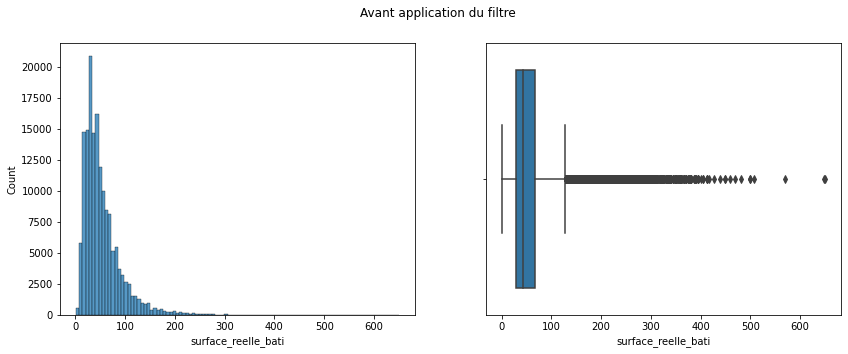

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", ax=axes[1]);  

In [22]:
df2 = df2.loc[
    (df2.surface_reelle_bati >= 9) & 
    (df2.surface_reelle_bati <= 250), 
    :
]

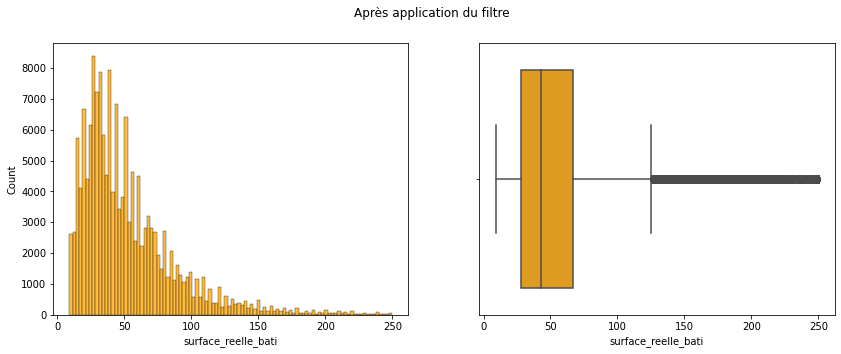

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Après application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", color="orange", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", color="orange", ax=axes[1]);  

In [24]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.587560e+05,158831.000000,136.000000,158667.000000,158667.000000,158831.000000,158831.000000,158831.000000,158831.000000,158831.000000,158831.000000
mean,5.664912e+05,52.892105,422.352941,2.340493,48.862257,0.278541,146896.483451,2019.484868,2.533636,6.622775,16.565759
std,8.382248e+05,36.019477,579.706650,0.037816,0.020026,0.448283,61785.247762,1.526210,1.109301,3.397678,8.881372
min,1.500000e-01,9.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.000000,1.000000
25%,2.575000e+05,28.000000,144.750000,2.311355,48.845670,0.000000,91932.000000,2018.000000,2.000000,4.000000,9.000000
50%,4.122500e+05,43.000000,210.500000,2.343432,48.862673,0.000000,165446.000000,2019.000000,3.000000,7.000000,17.000000
75%,6.750000e+05,67.000000,445.750000,2.371308,48.880036,1.000000,195060.000000,2021.000000,4.000000,10.000000,25.000000
max,1.315000e+08,250.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.000000,31.000000


In [25]:
df2.loc[df2.surface_reelle_bati==250, :].describe()

,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,4.000000e+01,40.0,0.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000
mean,3.282032e+06,250.0,NaN,2.301378,48.869575,0.525000,130038.500000,2019.375000,2.600000,6.87500,18.650000
std,1.902103e+06,0.0,NaN,0.021505,0.011070,0.505736,59974.673545,1.371645,1.236206,3.63168,8.368286
min,5.000000e+04,250.0,NaN,2.266537,48.846405,0.000000,16252.000000,2017.000000,1.000000,1.00000,1.000000
25%,2.549575e+06,250.0,NaN,2.285491,48.860895,0.000000,52512.000000,2018.000000,1.000000,3.00000,13.500000
50%,2.890842e+06,250.0,NaN,2.299666,48.867970,1.000000,165446.000000,2019.000000,3.000000,7.00000,19.500000
75%,3.672500e+06,250.0,NaN,2.309531,48.880958,1.000000,167835.000000,2020.250000,4.000000,10.00000,25.250000
max,9.202514e+06,250.0,NaN,2.359277,48.886915,1.000000,195060.000000,2022.000000,4.000000,12.00000,30.000000


On créé la variable `l_surface_reelle_bati` en appliquant le logarithme à la variable `surface_terrain`. 

In [26]:
df2["l_surface_reelle_bati"] = df2["surface_reelle_bati"].apply(lambda x: np.log(x)) 

#### Surface terrain

On commence par mettre à 0 les valeurs manquantes dans la colonne `surface_terrain`. 

In [27]:
def encode_field_area(area: float) -> float: 

    if pd.isna(area): 
        area = 0
    return area 

assert encode_field_area(float("nan")) == 0
assert encode_field_area(102.) == 102.
 
df2["surface_terrain"] = df2["surface_terrain"].apply(encode_field_area) 

In [28]:
df2["surface_terrain"].describe()

count    158831.000000
mean          0.361642
std          20.934422
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4006.000000
Name: surface_terrain, dtype: float64

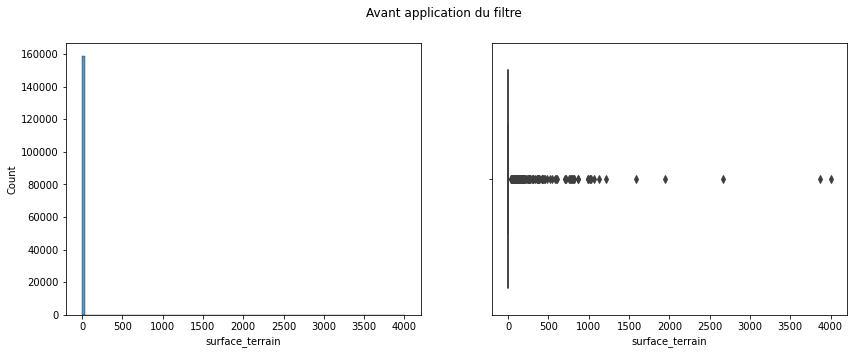

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_terrain", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_terrain", ax=axes[1]);  

In [30]:
df2.loc[df2.surface_terrain == 0].shape[0] / df2.shape[0]

0.9991437439794498

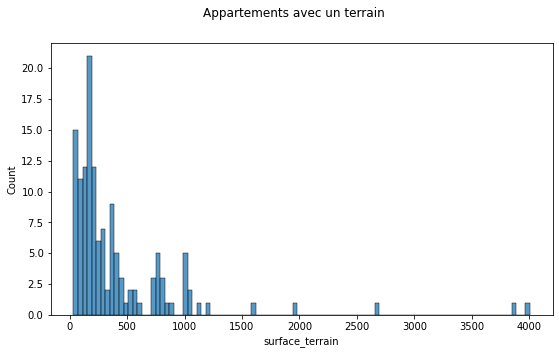

In [31]:
fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle("Appartements avec un terrain")

sns.histplot(
    data=df2.loc[df2.surface_terrain != 0], 
    x="surface_terrain", 
    bins=100, 
    ax=ax); 

La surface du terrain est nulle pour la majorité des biens (99.91%), ce qui fait sens puisque ce sont des appartements à Paris. On décide d'ajouter la dummy `terrain` qui vaut 1 si `surface_terrain` est non nulle. 

In [32]:
def has_field(fiedl_area: float) -> bool: 
    if fiedl_area > 0: 
        return 1 
    return 0

df2["terrain"] = df2["surface_terrain"].apply(has_field)

In [33]:
avg_field = df2.loc[df2.terrain==1]["valeur_fonciere"].mean()
avg_no_field = df2.loc[df2.terrain==0]["valeur_fonciere"].mean()

print(f"Valeur foncière moyenne \nAvec terrain : {round(avg_field, 2):,}€ \nSans terrain {round(avg_no_field, 2):,}€")

Valeur foncière moyenne 
Avec terrain : 11,651,737.04€ 
Sans terrain 557,056.72€

In [34]:
df2.loc[df2.terrain==0]["valeur_fonciere"].describe()

count    1.586210e+05
mean     5.570567e+05
std      5.304231e+05
min      1.500000e-01
25%      2.572500e+05
50%      4.120000e+05
75%      6.750000e+05
max      2.700000e+07
Name: valeur_fonciere, dtype: float64

In [35]:
df2.loc[df2.terrain==1]["valeur_fonciere"].describe()

count    1.350000e+02
mean     1.165174e+07
std      1.937720e+07
min      2.000000e+00
25%      1.575000e+06
50%      3.100000e+06
75%      1.215000e+07
max      1.315000e+08
Name: valeur_fonciere, dtype: float64

Les appartements avec terrain semblent être des anomalies. On décide de les enlever du jeu de données. 

In [36]:
df2 = df2.loc[df2.terrain==0].drop(labels=["terrain", "surface_terrain"], axis=1)

### Variable cible : `valeur_fonciere`

In [37]:
df2["valeur_fonciere"].describe()

count    1.586210e+05
mean     5.570567e+05
std      5.304231e+05
min      1.500000e-01
25%      2.572500e+05
50%      4.120000e+05
75%      6.750000e+05
max      2.700000e+07
Name: valeur_fonciere, dtype: float64

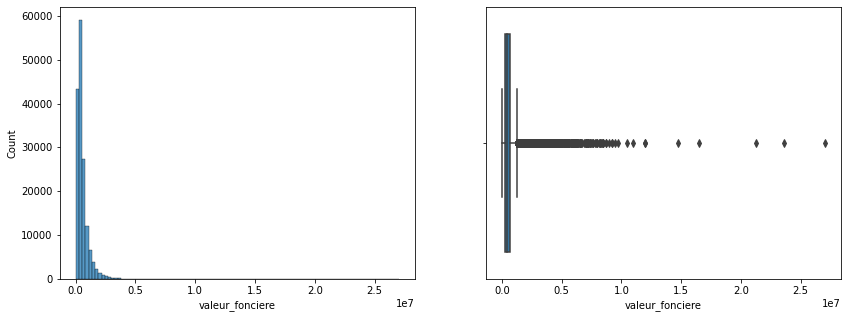

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data=df2, x="valeur_fonciere", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="valeur_fonciere", ax=axes[1]);  

On décide de transfomer la variable `valeur_fonciere` en divisant par la surface du bien (en m²). On obtient la variable `valeur_fonciere_m2`: 

$$
\text{valeur\_fonciere\_m2} = \frac{\text{valeur\_fonciere}}{\text{surface\_reelle\_bati}}
$$

On choisit aussi d"appliquer le logarithme aux variables `valeur_fonciere` et `valeur_fonciere_m2`: 

$$
\begin{aligned}
\text{l\_valeur\_fonciere\_m2} & = \log (\text{valeur\_fonciere\_m2}) \\
\text{l\_valeur\_fonciere} & = \log (\text{valeur\_fonciere})
\end{aligned}
$$


In [39]:
from typing import Optional

def transform_target_variable(price: float, log:bool, area: Optional[float]=None) -> float: 

    y = price

    if area != None: 
        y = y / area

    if log: 
        y = np.log(y)
    
    return y 

df2["valeur_fonciere_m2"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere, False, row.surface_reelle_bati), axis=1) 
df2["l_valeur_fonciere_m2"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere_m2, True), axis=1) 
df2["l_valeur_fonciere"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere, True), axis=1) 

In [40]:
for target in ("valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"): 
    display(df2[target].describe())

count    1.586210e+05
mean     1.038302e+04
std      6.773844e+03
min      3.750000e-03
25%      8.551724e+03
50%      1.018313e+04
75%      1.191358e+04
max      1.176559e+06
Name: valeur_fonciere_m2, dtype: float64

count    158621.000000
mean         12.849294
std           1.141658
min          -1.897120
25%          12.457804
50%          12.928779
75%          13.422468
max          17.111347
Name: l_valeur_fonciere, dtype: float64

count    158621.000000
mean          9.081044
std           0.962552
min          -5.585999
25%           9.053888
50%           9.228488
75%           9.385434
max          13.978105
Name: l_valeur_fonciere_m2, dtype: float64

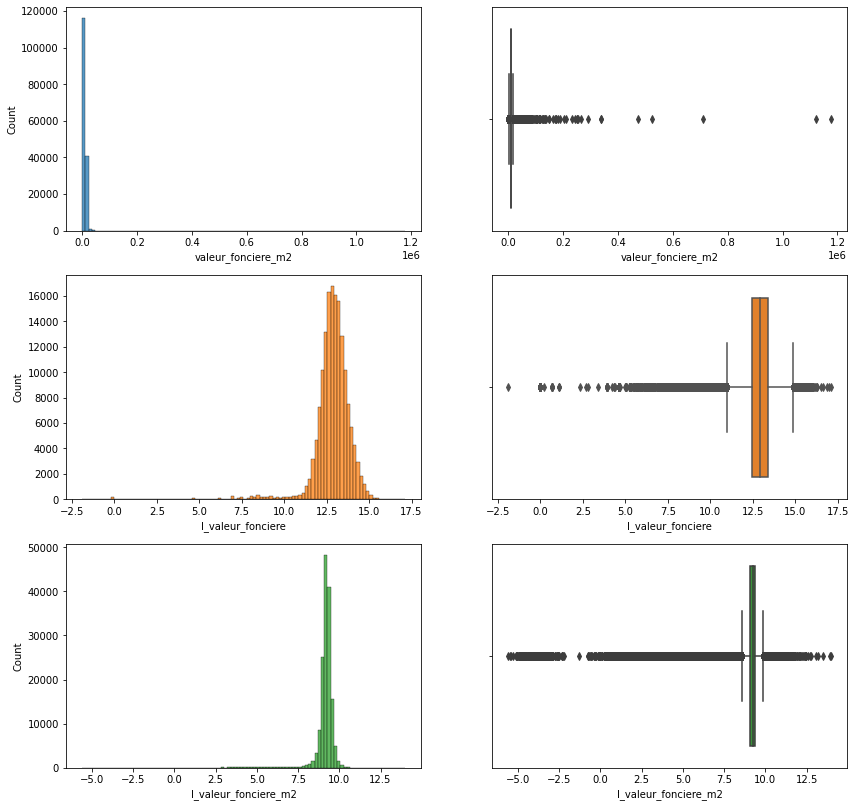

In [41]:
colors = sns.color_palette(n_colors=3)
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 14))

for ix, target in enumerate(["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]): 

    sns.histplot(data=df2, x=target, bins=100, ax=axes[ix, 0], color=colors[ix])
    sns.boxplot(data=df2, x=target, ax=axes[ix, 1], color=colors[ix]); 

D"après l"estimation faite par [meilleursagents](https://www.meilleursagents.com/prix-immobilier/paris-75000/), le prix/m² des appartements à Paris peut valoir entre de 6 847 € à 16 324 €. Afin d"être moins restrictif et pour prendre en compte les éventuelles fluctuations, on décide de sélectionner les biens tq $\text{valeur\_fonciere\_m2} \in [5 000, 20 000]$.

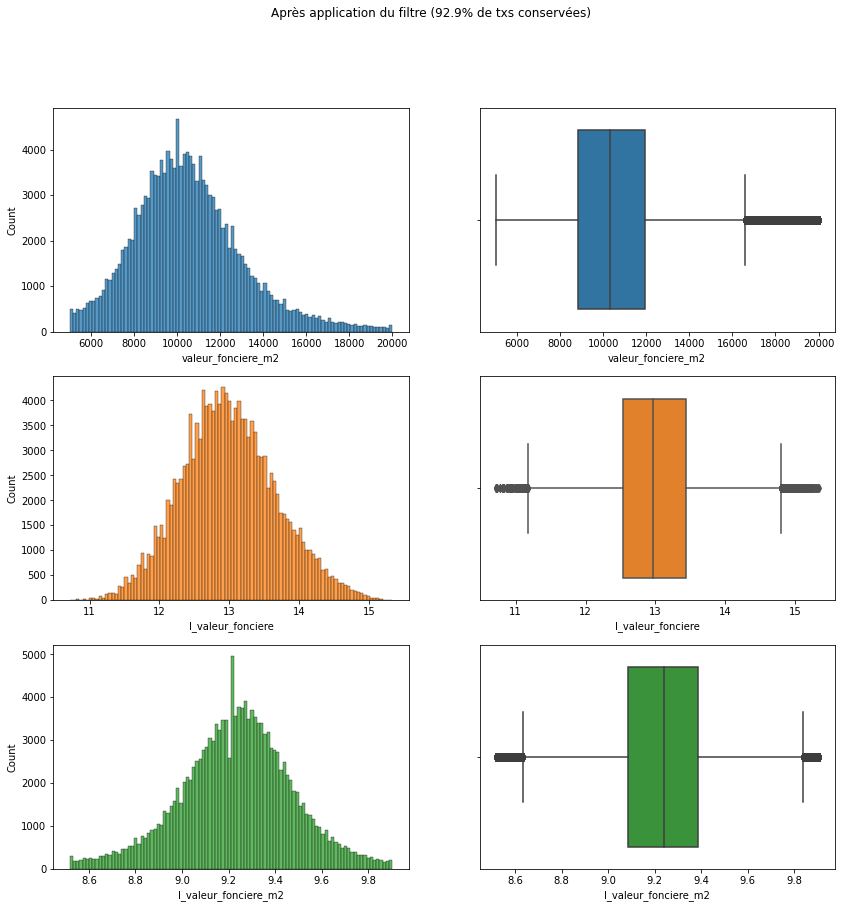

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 14))

tmp = df2.loc[
    (df2.valeur_fonciere_m2 >= 5000) & 
    (df2.valeur_fonciere_m2 <= 20000), 
    :
]
prop = tmp.shape[0] / df2.shape[0]

fig.suptitle(f"Après application du filtre ({round(100 *prop, 2)}% de txs conservées)")

for ix, target in enumerate(["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]): 

    sns.histplot(data=tmp, x=target, bins=100, ax=axes[ix, 0], color=colors[ix])
    sns.boxplot(data=tmp, x=target, ax=axes[ix, 1], color=colors[ix])

del tmp; 

In [43]:
df2 = df2.loc[
    (df2.valeur_fonciere_m2 >= 5000) & 
    (df2.valeur_fonciere_m2 <= 20000), 
    :
]

### Ajout de la variable `arrondissement`

On isole les arrondissements à partir de la variable `nom_commune`. 

In [44]:
DIGIT = r"[0-9]+"
import re

def extract_int_from_string(string: str) -> int: 
    integer = re.findall(DIGIT, string)

    if len(integer) > 1: 
        raise ValueError("Multiple integers found.")
    return integer[0]

In [45]:
df2["arrondissement"] = df2.nom_commune.apply(extract_int_from_string)

In [46]:
df2.arrondissement.value_counts() / df2.shape[0]

18    0.109865
15    0.108562
17    0.088335
16    0.086205
11    0.083458
20    0.067132
19    0.055879
12    0.054142
14    0.051924
10    0.051897
13    0.048539
9     0.037490
7     0.025999
5     0.025891
6     0.022072
3     0.021319
8     0.020125
2     0.016144
4     0.015581
1     0.009442
Name: arrondissement, dtype: float64

### Variables temporelles

On décide de construire la variable `trimestre_annee` qui est la concaténation des variables `trimestre` et `annee`. 

In [47]:
df2.trimestre

0         3
1         3
2         3
3         3
4         3
         ..
160752    2
160753    2
160754    2
160755    2
160756    2
Name: trimestre, Length: 147427, dtype: int64

In [48]:
def get_quarter_year(quarter: int, year: int) -> str: 
    return f"{year}Q{quarter}"

df2["trimestre_annee"] = df2.apply(lambda row: get_quarter_year(row.trimestre, row.annee), axis=1)

### Moyennes mobiles par quartier

L'objectif est de construire des variables permettant de prendre en compte l'évolution des prix du marché par arrondissement. Les moyennes mobiles sont un outil pertinent pour le faire. 

1. Aggrégation journalière (moyenne) des valeurs foncières par arrondissement
2. Appliquation d'un lag de 1 jour sur les valeurs agrégées par arrondissement
3. Moyenne mobile sur $k$ jours appliquée aux valeurs agrégées décalées par arrondissement

In [49]:
from pandas.core.frame import DataFrame
from typing import Optional

def calc_movav_prices(
    df: DataFrame, 
    window_size: int, 
    lag: int=1, 
    price_var: str="valeur_fonciere", 
    date_var: str="date_mutation", 
    neighborhood_var: Optional[str]="arrondissement"
) -> DataFrame: 
    """Description. Compute moving average prices per neighborhood.""" 

    if neighborhood_var != None: 
        by = [neighborhood_var, date_var]
    else:
        by = date_var

    avg_prices = df\
        .groupby(by)\
        [price_var]\
        .mean()\
        .shift(lag)

    if neighborhood_var != None: 
        avg_prices = avg_prices.groupby(neighborhood_var)

    mov_avg_prices = avg_prices\
        .apply(lambda x: x.rolling(window_size).mean())\
        .reset_index()\
        .rename(columns={price_var: f"{price_var}_ma{window_size}"})

    return mov_avg_prices

def add_movav_prices(
    df: DataFrame, 
    mov_av_prices: DataFrame, 
    date_var: str="date_mutation", 
    neighborhood_var: Optional[str]="arrondissement"
) -> DataFrame: 
    """Description. Merge moving average prices and DVF dataset."""

    keys = []
    if neighborhood_var != None: 
        keys.append(neighborhood_var) 
        
    keys.append(date_var)

    new_df = pd.merge(
        left=df, 
        right=mov_av_prices, 
        how="left", 
        left_on=keys, 
        right_on=keys)
    
    return new_df

def shift_movav_prices(df: DataFrame, lag: int) -> DataFrame: 
    """Description. Add n-day lag to moving average prices."""

    cols = df.columns[df.columns.str.contains("_ma")].tolist()
    df.loc[:, cols] = df2[cols].apply(lambda x: x.shift(lag))

    return df

In [50]:
# keep trace of moving average prices
mov_av_prices = {}

for window_size in (7, 14, 30, 90): 
    # calculate lagged moving average prices (lag=1)
    mov_av_prices[window_size] = calc_movav_prices(df2, window_size, lag=1)

    # add to dvf
    df2 = add_movav_prices(df2, mov_av_prices[window_size]) 

On décide d'appliquer le logarithme aux moyennes mobiles que nous venons de calculer.

In [51]:
ma_vars = [
    "valeur_fonciere_ma7",
    "valeur_fonciere_ma14",
    "valeur_fonciere_ma30",
    "valeur_fonciere_ma90"
]

for var in ma_vars: 
    df2[f"l_{var}"] = df2[var].apply(lambda x: np.log(x))

In [52]:
df2.columns

Index(['id_mutation', 'date_mutation', 'valeur_fonciere', 'nom_commune',
       'surface_reelle_bati', 'nombre_pieces_principales', 'longitude',
       'latitude', 'dependance', 'pop', 'annee', 'trimestre', 'mois', 'jour',
       'l_surface_reelle_bati', 'valeur_fonciere_m2', 'l_valeur_fonciere_m2',
       'l_valeur_fonciere', 'arrondissement', 'trimestre_annee',
       'valeur_fonciere_ma7', 'valeur_fonciere_ma14', 'valeur_fonciere_ma30',
       'valeur_fonciere_ma90', 'l_valeur_fonciere_ma7',
       'l_valeur_fonciere_ma14', 'l_valeur_fonciere_ma30',
       'l_valeur_fonciere_ma90'],
      dtype='object')

### Encodage du type des variables

In [53]:
CAT_VARS = [
    "nombre_pieces_principales", 
    "dependance", 
    "arrondissement", 
    "trimestre" 
]

QUANT_VARS = [
    "valeur_fonciere",
    "l_valeur_fonciere", 
    "valeur_fonciere_m2", 
    "l_valeur_fonciere_m2", 
    "valeur_fonciere_ma7",
    "valeur_fonciere_ma14",
    "valeur_fonciere_ma30",
    "valeur_fonciere_ma90", 
    "l_valeur_fonciere_ma7",
    "l_valeur_fonciere_ma14",
    "l_valeur_fonciere_ma30",
    "l_valeur_fonciere_ma90", 
    "surface_reelle_bati", 
    "l_surface_reelle_bati"
]

ID_VARS = ["id_mutation", "date_mutation"]

df3 = df2.loc[:, ID_VARS+QUANT_VARS+CAT_VARS]

df3.loc[:, CAT_VARS] = df2.loc[:, CAT_VARS].astype(object)
df3.loc[:, QUANT_VARS] = df3.loc[:, QUANT_VARS].astype(float)

In [54]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147427 entries, 0 to 147426
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id_mutation                147427 non-null  object        
 1   date_mutation              147427 non-null  datetime64[ns]
 2   valeur_fonciere            147427 non-null  float64       
 3   l_valeur_fonciere          147427 non-null  float64       
 4   valeur_fonciere_m2         147427 non-null  float64       
 5   l_valeur_fonciere_m2       147427 non-null  float64       
 6   valeur_fonciere_ma7        146515 non-null  float64       
 7   valeur_fonciere_ma14       145415 non-null  float64       
 8   valeur_fonciere_ma30       143344 non-null  float64       
 9   valeur_fonciere_ma90       136169 non-null  float64       
 10  l_valeur_fonciere_ma7      146515 non-null  float64       
 11  l_valeur_fonciere_ma14     145415 non-null  float64 

### Visualisation 

In [55]:
df3[QUANT_VARS]\
    .corr(method="pearson")\
    [["valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"]]

,valeur_fonciere_m2,l_valeur_fonciere,l_valeur_fonciere_m2
valeur_fonciere,0.417258,0.897535,0.402279
l_valeur_fonciere,0.408634,1.000000,0.414611
valeur_fonciere_m2,1.000000,0.408634,0.984423
l_valeur_fonciere_m2,0.984423,0.414611,1.000000
valeur_fonciere_ma7,0.376873,0.319611,0.364331
valeur_fonciere_ma14,0.395271,0.332846,0.382199
valeur_fonciere_ma30,0.407175,0.340392,0.393389
valeur_fonciere_ma90,0.411719,0.345001,0.397255
l_valeur_fonciere_ma7,0.393163,0.324629,0.384575
l_valeur_fonciere_ma14,0.412997,0.337268,0.403812


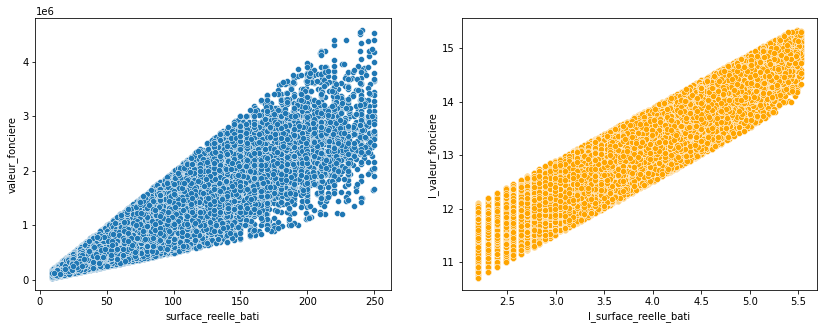

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(data=df3, x="surface_reelle_bati", y="valeur_fonciere", ax=axes[0])
sns.scatterplot(data=df3, x="l_surface_reelle_bati", y="l_valeur_fonciere", color="orange", ax=axes[1]); 

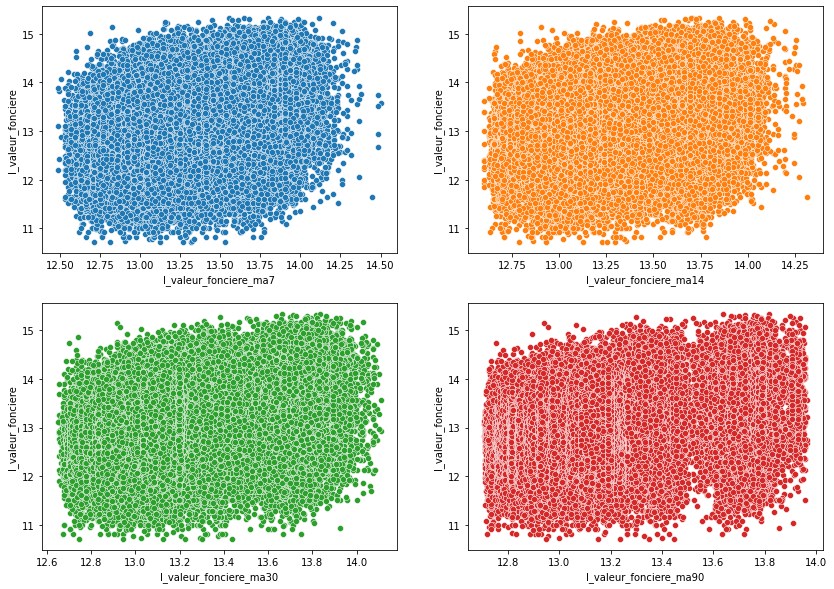

In [57]:
ma_vars = [
    "valeur_fonciere_ma7",
    "valeur_fonciere_ma14",
    "valeur_fonciere_ma30",
    "valeur_fonciere_ma90"
]

colors = sns.color_palette(n_colors=len(ma_vars))

target = "l_valeur_fonciere"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10)) 

for var, color, ax in zip(ma_vars, colors, axes.flatten()): 

    if target == "l_valeur_fonciere": 
        var = f"l_{var}"

    sns.scatterplot(data=df3, x=var, y=target, color=color, ax=ax); 

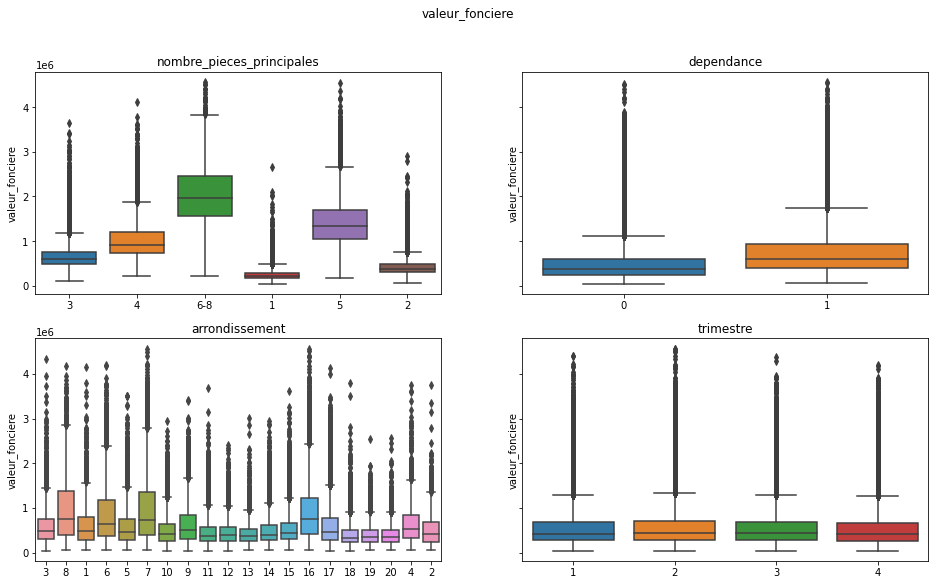

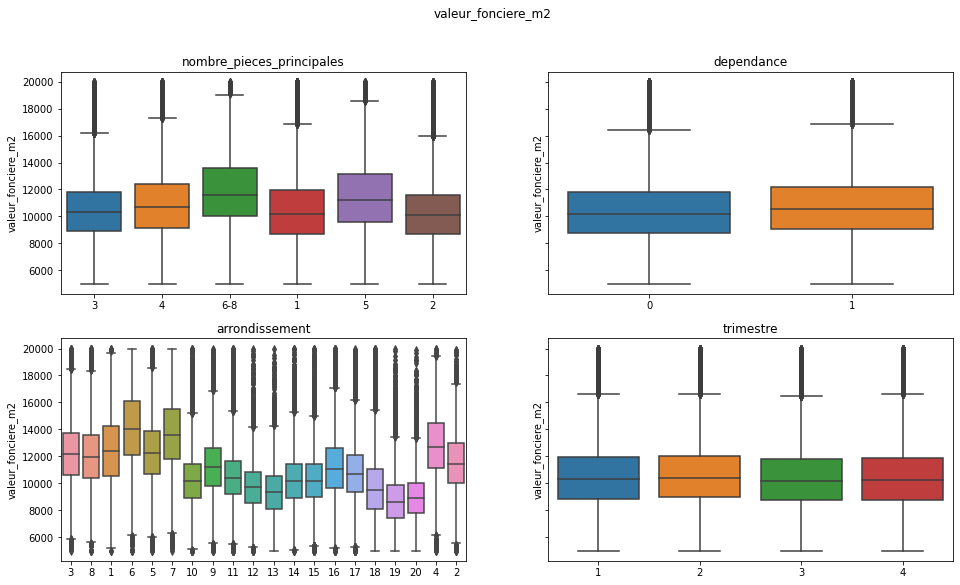

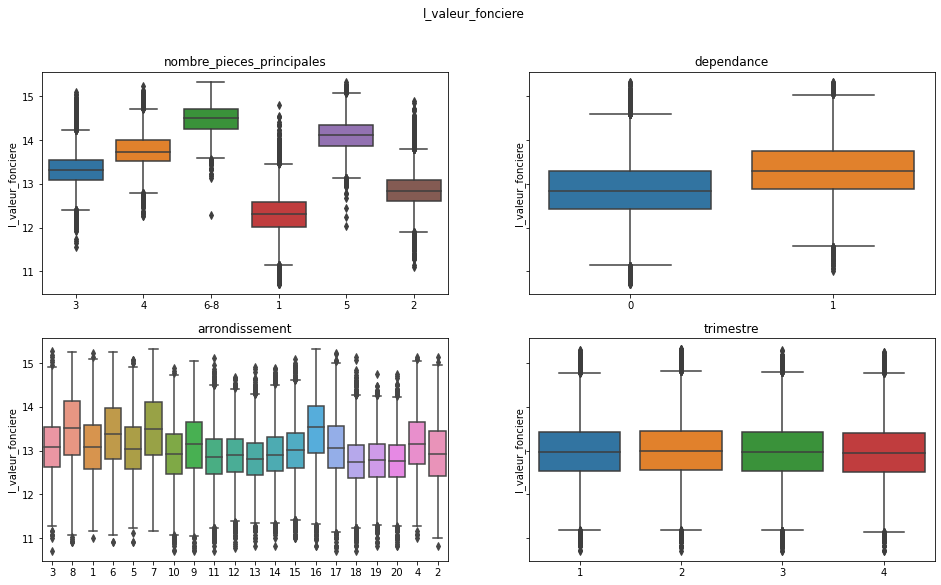

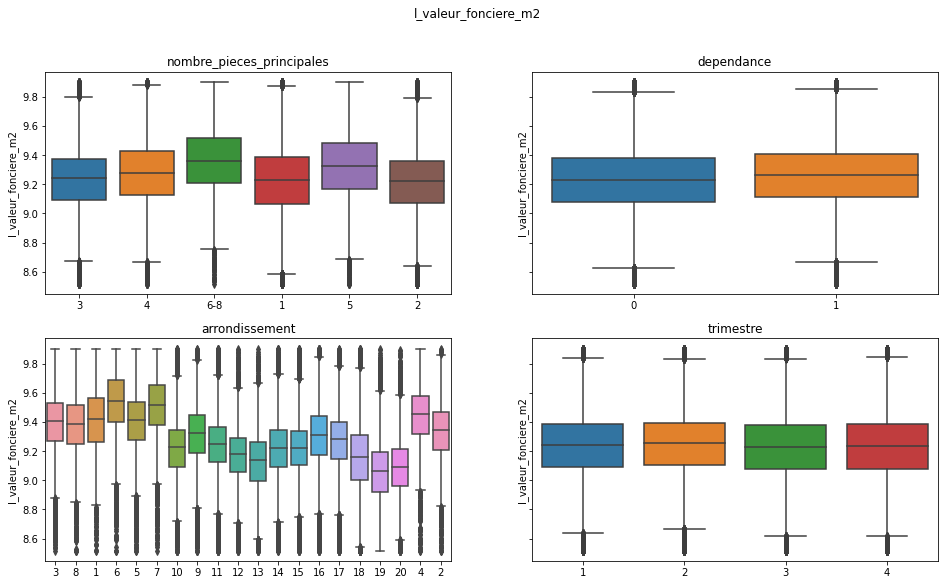

In [58]:
for target in ("valeur_fonciere", "valeur_fonciere_m2", "l_valeur_fonciere", "l_valeur_fonciere_m2"): 

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9), sharey=True)
    fig.suptitle(target)

    for var, ax in zip(CAT_VARS, axes.flatten()):
        sns.boxplot(data=df3, x=var, y=target, ax=ax)

        if var == "trimestre_annee": 
            ax.tick_params(axis="x", rotation=90)

        ax.set_title(var)
        ax.set_xlabel(""); 

C:\Users\pemma\AppData\Local\Temp/ipykernel_20576/935798534.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_evol = df3\


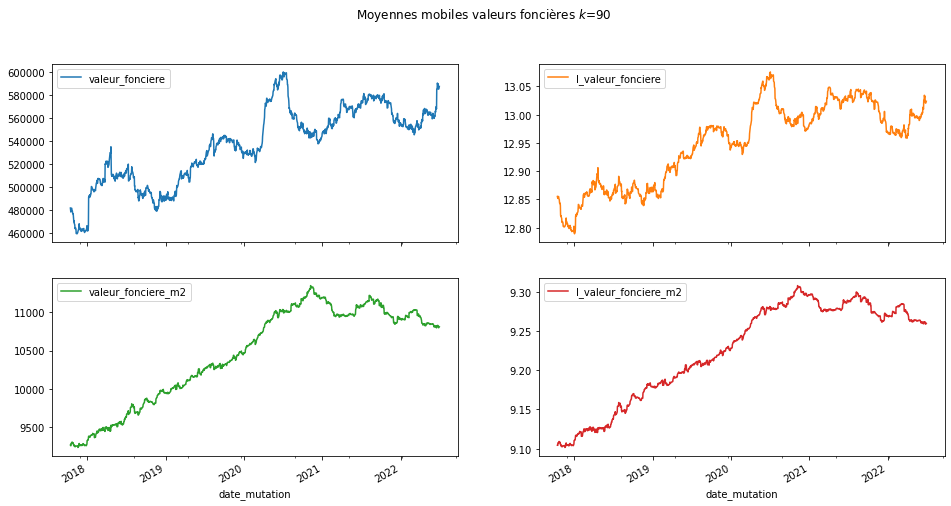

In [59]:
price_evol = df3\
    .groupby(["date_mutation"])\
    ["valeur_fonciere", "l_valeur_fonciere", "valeur_fonciere_m2", "l_valeur_fonciere_m2"]\
    .mean() 

k = 90

price_evol\
    .rolling(window=k)\
    .mean()\
    .plot(
        subplots=True, 
        layout=(2, 2), 
        figsize=(16, 8), 
        title=rf"Moyennes mobiles valeurs foncières $k$={k}");

In [60]:
import plotly.express as px 

k = 30 

price_evol_arr = df3\
    .groupby(["arrondissement", "date_mutation"])\
    ["valeur_fonciere"]\
    .mean()\
    .rolling(window=k)\
    .mean()\
    .reset_index()

fig = px.line(
    price_evol_arr, 
    x="date_mutation", 
    y="valeur_fonciere", 
    color="arrondissement")

fig.show()

### Sélection des variables 

In [61]:
df3.columns

Index(['id_mutation', 'date_mutation', 'valeur_fonciere', 'l_valeur_fonciere',
       'valeur_fonciere_m2', 'l_valeur_fonciere_m2', 'valeur_fonciere_ma7',
       'valeur_fonciere_ma14', 'valeur_fonciere_ma30', 'valeur_fonciere_ma90',
       'l_valeur_fonciere_ma7', 'l_valeur_fonciere_ma14',
       'l_valeur_fonciere_ma30', 'l_valeur_fonciere_ma90',
       'surface_reelle_bati', 'l_surface_reelle_bati',
       'nombre_pieces_principales', 'dependance', 'arrondissement',
       'trimestre'],
      dtype='object')

In [62]:
to_select = [
    "id_mutation", 
    "date_mutation", 
    "l_valeur_fonciere",            # target
    "l_valeur_fonciere_ma7",
    "l_valeur_fonciere_ma14",
    "l_valeur_fonciere_ma30",
    "l_valeur_fonciere_ma90", 
    "l_surface_reelle_bati",
    "nombre_pieces_principales", 
    "dependance", 
    "arrondissement",
    "trimestre",     
]

df_mod = df3[to_select]
df_mod = df_mod.dropna(axis=0)

df_mod = df_mod.set_index("id_mutation")

In [63]:
n, p = df_mod.shape
prop = 100 * n / df3.shape[0]

print(f"{p} variables et {n:,} observations -> {round(prop, 2)}% d'observations conservées")

11 variables et 136,169 observations -> 92.36% d'observations conservées

## Train/test split

On classe les transactions par ordre chronologique et on divise le jeu de données en 2: 
- 80% de données train 
- 20% de données test

Il est important de prendre en compte les effets fixes temporels liés aux valeurs foncières (prix du marché). Pour cela, on peut actualiser les valeurs prises par la variable `valeur_fonciere` selon un prix de référence. Ce prix de référence correspond au prix du bien de référence pour la date la plus récente du jeu de données train. 

Caractéristiques du bien de référence pour les appartements de Paris : 

|  Variable | Référence  |
|---|---|
| `nombre_pieces_principales`  | 2  |
|  `arrondissement` | 15  |
| `surface_reelle_bati`  | 40 (m²)  |
| `dependance`  | 0 |

In [64]:
from pandas.core.frame import DataFrame
from pandas.core.series import Series 
from typing import Tuple

def sort_transaction_dates(df: DataFrame, date_var: str) -> Series: 
    """Description. Store id_mutation and date_mutation."""
    
    transaction_dates = df[date_var].sort_values(ascending=True)
    return transaction_dates 

def temporal_train_test_split(df: DataFrame, date_var: str, train_prop: float) -> Tuple: 
    """Description. Temporal train/test split."""

    transaction_dates = sort_transaction_dates(df, date_var)

    train_size = int(transaction_dates.shape[0] * train_prop)
    training_idxs = transaction_dates[:train_size].index

    df_train = df.loc[df.index.isin(training_idxs), :].sort_values(by=date_var)
    df_test = df.loc[~df.index.isin(training_idxs), :].sort_values(by=date_var)

    train_dates = sort_transaction_dates(df_train, date_var)
    test_dates = sort_transaction_dates(df_test, date_var)

    return (
        df_train.drop([date_var], axis=1), 
        df_test.drop([date_var], axis=1), 
        train_dates, 
        test_dates 
    )  

df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_mod, "date_mutation", train_prop=.8)

In [65]:
assert df_train.shape[0] + df_test.shape[0] == df_mod.shape[0]

In [66]:
train_dates.tail()

id_mutation
2021-1605563   2021-08-23
2021-1590416   2021-08-23
2021-1589948   2021-08-23
2021-1590122   2021-08-23
2021-1605494   2021-08-23
Name: date_mutation, dtype: datetime64[ns]

In [67]:
test_dates.head()

id_mutation
2021-1589842   2021-08-23
2021-1590494   2021-08-23
2021-1589949   2021-08-23
2021-1590502   2021-08-23
2021-1590583   2021-08-23
Name: date_mutation, dtype: datetime64[ns]

### Transformation des variables catégorielles

On transforme chaque variable catégorielle $\mathrm{x}_{cat, k}$, contenant $n_k$ niveaux, en $n_k-1$ variables indicatrices. 

Les variables considérées sont : 
- `nombre_pieces_princicpales`
- `dependance`
- `trimestre`
- `arrondissement`

On peut utiliser la fonction `pd.get_dummies()` pour transformer les variables catégorielles.

In [68]:
df_train = pd.get_dummies(data=df_train, drop_first=False)
df_test = pd.get_dummies(data=df_test, drop_first=False)

In [69]:
df_train.head()

,l_valeur_fonciere,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,l_surface_reelle_bati,nombre_pieces_principales_1,nombre_pieces_principales_2,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6-8,dependance_0,dependance_1,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9,trimestre_1,trimestre_2,trimestre_3,trimestre_4
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-743666,12.230765,13.105373,13.108966,13.077305,13.09004,2.890372,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-743563,13.251636,13.105373,13.108966,13.077305,13.09004,4.110874,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-743590,12.644328,13.105373,13.108966,13.077305,13.09004,3.784190,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-743566,12.628067,13.105373,13.108966,13.077305,13.09004,3.295837,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-743766,13.296317,13.105373,13.108966,13.077305,13.09004,4.234107,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [70]:
from pandas.core.frame import DataFrame
from typing import Dict


def format_df(df: DataFrame, reference_levels: Dict) -> DataFrame: 
    """Description. Format dataset columns based on reference levels."""

    for var, lvl in reference_levels.items(): 
        var_name = f"{var}_{lvl}"
        if var_name in df.columns: 
            df = df.drop([var_name], axis=1) 

    return df   

In [71]:
reference_levels = {
    "nombre_pieces_principales": 2,
    "arrondissement": 15, 
    "trimestre": 3, 
    "dependance": 0
}

df_train = format_df(df_train, reference_levels)
df_test = format_df(df_test, reference_levels)

In [72]:
df_train.columns

Index(['l_valeur_fonciere', 'l_valeur_fonciere_ma7', 'l_valeur_fonciere_ma14',
       'l_valeur_fonciere_ma30', 'l_valeur_fonciere_ma90',
       'l_surface_reelle_bati', 'nombre_pieces_principales_1',
       'nombre_pieces_principales_3', 'nombre_pieces_principales_4',
       'nombre_pieces_principales_5', 'nombre_pieces_principales_6-8',
       'dependance_1', 'arrondissement_1', 'arrondissement_10',
       'arrondissement_11', 'arrondissement_12', 'arrondissement_13',
       'arrondissement_14', 'arrondissement_16', 'arrondissement_17',
       'arrondissement_18', 'arrondissement_19', 'arrondissement_2',
       'arrondissement_20', 'arrondissement_3', 'arrondissement_4',
       'arrondissement_5', 'arrondissement_6', 'arrondissement_7',
       'arrondissement_8', 'arrondissement_9', 'trimestre_1', 'trimestre_2',
       'trimestre_4'],
      dtype='object')

### Interaction `nombre_pieces_principales` & `surface_relle_bati`

In [73]:
def add_area_rooms_interaction(df: DataFrame, area_var: str, num_rooms_var: str) -> DataFrame: 
    """Description. Add interaction variables between surface area and number of rooms."""

    dummy_cols = df.columns[df.columns.str.contains(num_rooms_var)].tolist()
    
    for col in dummy_cols:
        var_name = f"{area_var}_{col}"
        df[var_name] = df[area_var] * df[col]

    return df

df_train = add_area_rooms_interaction(df_train, "l_surface_reelle_bati", "nombre_pieces_principales")
df_test = add_area_rooms_interaction(df_test, "l_surface_reelle_bati", "nombre_pieces_principales")

### Actualisation des prix

```python
target = "valeur_fonciere"
features = df_train.drop(labels=[target], axis=1).columns.tolist()

X = df_train.drop(labels=[target], axis=1)
y = df_train[target]

X_, y_ = X.values, y.values

lr = LinearRegression()

lr.fit(X_, y_)

coefs = {
    f: coef
    for f, coef in zip(features, lr.coef_)
}

intercept = lr.intercept_

valeur_fonciere_ref = lr.intercept_ + coefs["surface_reelle_bati"] * reference_levels["surface_reelle_bati"]
print(f"Prix estimé du bien de référence : {round(valeur_fonciere_ref, 2):,}€")

def update_price(x: float, ref_price: float) -> float:
    
    return (x - ref_price) / ref_price

df_train["valeur_fonciere_act"] = df_train["valeur_fonciere"].apply(lambda p: update_price(p, valeur_fonciere_ref))
```

**Formule d"actualisation des prix**

$$
p_i^{'} = \frac{p_i - p_0}{p_0}
$$

avec $p_0$ le prix de référence. 

In [74]:
target = "l_valeur_fonciere"
features = df_train.drop([target], axis=1).columns.tolist()

X_tr, X_te = df_train.drop([target], axis=1).values, df_test.drop([target], axis=1).values
y_tr, y_te = df_train[target].values, df_test[target].values 

## Modèles de régression

Un modèle par variable cible : `valeur_fonciere`, `l_valeur_fonciere` et `l_valeur_fonciere_m2`. 

On commence par entrainer plusieurs régresseurs sans optimiser les hyperparamètres. L"objectif est d"avoir un aperçu des types de régresseurs qui permettent d"obtenir les meilleurs scores à savoir MAPE et R². 

In [75]:
from sklearn.base import BaseEstimator
from typing import Dict, Optional

class CustomRegressor(BaseEstimator):
    """Description. A Custom BaseEstimator that can switch between regressors.""" 

    def __init__(self, estimator=LinearRegression()):
        self.estimator = estimator

    def fit(self, X: np.ndarray, y: Optional[np.ndarray]=None, **kwargs: Dict):
        self.estimator.fit(X, y)
        return self

    def predict(self, X: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
        return self.estimator.predict(X) 

    def score(self, X: np.ndarray, y: np.ndarray, scoring: str="r2") -> float:
        if scoring == "r2": 
            return self.estimator.score(X, y)
        elif scoring == "mae": 
            y_pred = self.predict(X)
            return mean_absolute_error(y, y_pred)
        elif scoring == "mape":
            y_pred = self.predict(X)
            return mean_absolute_percentage_error(y, y_pred)
        elif scoring == "mse": 
            y_pred = self.predict(X)
            return mean_squared_error(y, y_pred)
        else: 
            return NotImplementedError

In [76]:
from rich.table import Table
from rich.console import Console

from typing import List

def make_regression_report(results: List) -> Table: 

    title = f"Résultats pour {target}"
    table = Table(title=title)

    table.add_column("Model")

    table.add_column("MAE train")
    table.add_column("MAE test")

    table.add_column("% MAPE train")
    table.add_column("% MAPE test")

    table.add_column("MSE train")
    table.add_column("MSE test")

    table.add_column("% R² train")
    table.add_column("% R² test")


    for model, record in results.items(): 
        (
            _, 
            mae_tr, mae_val, 
            mape_tr, mape_val, 
            mse_tr, mse_val, 
            r2_tr, r2_val
        ) = list(record.values())

        table.add_row(
            model, 
            str(round(mae_tr, 2)), 
            str(round(mae_val, 2)), 
            str(round(100*mape_tr, 2)), 
            str(round(100*mape_val, 2)),
            str(round(mse_tr, 2)), 
            str(round(mse_val, 2)), 
            str(round(100*r2_tr, 2)),
            str(round(100*r2_val, 2))
        )

    console = Console()
    console.print(table)

#### Benchmark - `DummyRegressor`

Prédiction par la moyenne. 

In [78]:
# intialize dict to save sklearn results 

sk_results = {}

In [79]:
dummy = CustomRegressor(estimator=DummyRegressor())

dummy.fit(X_tr, y_tr) 

mae_tr = dummy.score(X_tr, y_tr, scoring="mae")
mae_te = dummy.score(X_te, y_te, scoring="mae")

mape_tr = dummy.score(X_tr, y_tr, scoring="mape")
mape_te = dummy.score(X_te, y_te, scoring="mape")

mse_tr = dummy.score(X_tr, y_tr, scoring="mse")
mse_te = dummy.score(X_te, y_te, scoring="mse")

r2_tr = dummy.score(X_tr, y_tr, scoring="r2")
r2_te = dummy.score(X_te, y_te, scoring="r2")

sk_results[dummy.estimator.__class__.__name__] = {
    "model": dummy, 
    "mae_tr": mae_tr, 
    "mae_te": mae_te, 
    "mape_tr": mape_tr, 
    "mape_te": mape_te, 
    "mse_tr": mse_tr, 
    "mse_te": mse_te, 
    "r2_tr": r2_tr, 
    "r2_te": r2_te
}

In [80]:
make_regression_report(sk_results)

                              Résultats pour l_valeur_fonciere                               
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Model   ┃ MAE     ┃ MAE     ┃ % MAPE  ┃ % MAPE  ┃ MSE      ┃ MSE     ┃ % R²     ┃ % R²    ┃
┃         ┃ train   ┃ test    ┃ train   ┃ test    ┃ train    ┃ test    ┃ train    ┃ test    ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ DummyR… │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

#### Modèles linéaires

On décide d"estimer les modèles linéaire implémentés dans la librairie `sklearn` : 
- OLS : `LinearRegression`
- OLS avec pénalisation : `Ridge`, `Lasso`, `ElasticNet` 

In [81]:
linear_regressors = [
    LinearRegression(), 
    Ridge(), 
    Lasso(), 
    ElasticNet()
]

for estimator in linear_regressors:
    model = CustomRegressor(estimator)
    model_name = estimator.__class__.__name__

    model.fit(X_tr, y_tr)

    mae_tr = model.score(X_tr, y_tr, scoring="mae")
    mae_te = model.score(X_te, y_te, scoring="mae")

    mape_tr = model.score(X_tr, y_tr, scoring="mape")
    mape_te = model.score(X_te, y_te, scoring="mape")

    mse_tr = model.score(X_tr, y_tr, scoring="mse")
    mse_te = model.score(X_te, y_te, scoring="mse")

    r2_tr = model.score(X_tr, y_tr, scoring="r2")
    r2_te = model.score(X_te, y_te, scoring="r2")

    sk_results[model_name] = {
        "model": model, 
        "mae_tr": mae_tr, 
        "mae_te": mae_te, 
        "mape_tr": mape_tr, 
        "mape_te": mape_te, 
        "mse_tr": mse_tr, 
        "mse_te": mse_te, 
        "r2_tr": r2_tr, 
        "r2_te": r2_te
    }

In [82]:
make_regression_report(sk_results)

                              Résultats pour l_valeur_fonciere                               
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Model   ┃ MAE     ┃ MAE     ┃ % MAPE  ┃ % MAPE  ┃ MSE      ┃ MSE     ┃ % R²     ┃ % R²    ┃
┃         ┃ train   ┃ test    ┃ train   ┃ test    ┃ train    ┃ test    ┃ train    ┃ test    ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ DummyR… │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Linear… │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Ridge   │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Lasso   │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Elasti… │ 0.54    │ 0.54    │ 4.16    │ 4.1     │ 0.46     │ 0.46    │ 1.68     │ 0.96    │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

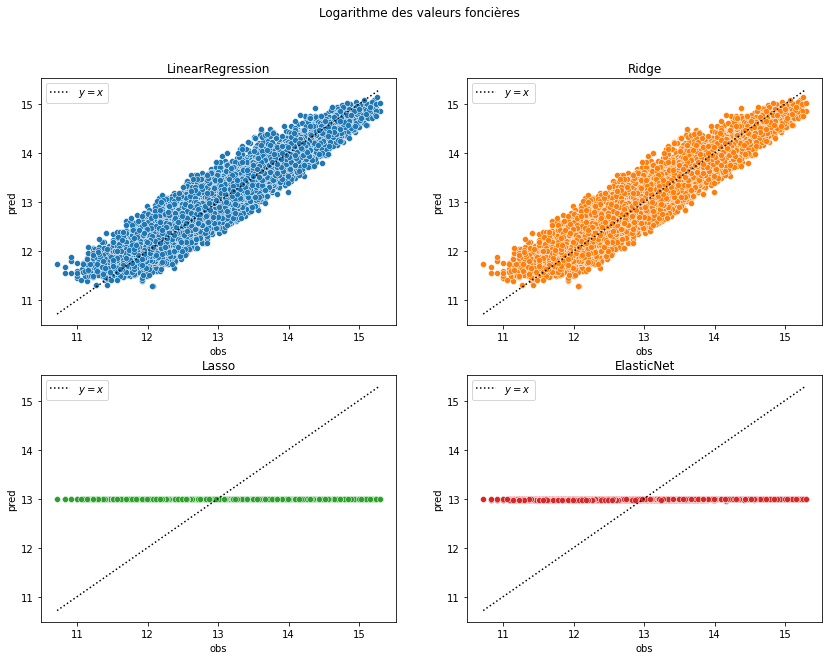

In [83]:
models = ["LinearRegression", "Ridge", "Lasso", "ElasticNet"]
colors = sns.color_palette(n_colors=4)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle("Logarithme des valeurs foncières")

for model_name, color, ax in zip(models, colors, axes.flatten()): 

    m = sk_results[model_name]["model"]
    y_pred = m.predict(X_te) 

    tmp = pd.DataFrame(data={"obs": y_te, "pred": y_pred})

    min_x, max_x = tmp.obs.min(), tmp.obs.max()

    sns.scatterplot(data=tmp, x="obs", y="pred", color=color, ax=ax)
    sns.lineplot(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        label=r"$y=x$", 
        color="black", 
        linestyle="dotted", 
        ax=ax)

    ax.legend()

    ax.set_title(model_name); 

In [84]:
table = Table(title="Coefficients estimés")

table.add_column("Variable")
table.add_column("LinearRegression")
table.add_column("Ridge")

lr_coefs = sk_results["LinearRegression"]["model"].estimator.coef_
ridge_coefs = sk_results["Ridge"]["model"].estimator.coef_

for feature, lr_coef, ridge_coef in zip(features, lr_coefs, ridge_coefs): 
    table.add_row(
        feature, 
        str(lr_coef), 
        str(ridge_coef)
    )

table.add_row(
    "Intercept", 
    str(sk_results["LinearRegression"]["model"].estimator.intercept_), 
    str(sk_results["Ridge"]["model"].estimator.intercept_)
)

console = Console()
console.print(table)

                                    Coefficients estimés                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Variable                                ┃ LinearRegression       ┃ Ridge                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ l_valeur_fonciere_ma7                   │ -0.003394894889144648  │ -0.0033522062918635164 │
│ l_valeur_fonciere_ma14                  │ 0.0024497002284495917  │ 0.002421749887586486   │
│ l_valeur_fonciere_ma30                  │ 0.015219965771565213   │ 0.017373509601496303   │
│ l_valeur_fonciere_ma90                  │ 0.6745755929484101     │ 0.6703113659558683     │
│ l_surface_reelle_bati                   │ 0.9344287888677938     │ 0.9349392021655181     │
│ nombre_pieces_principales_1             │ -0.005327004139734167  │ -0.0033819645575259645 │
│ nombre_pieces_principales_3             │ -0.07277417785987605   │ -0.06982982084481369   │
│ nombre_pieces_principales_4             │ -0.30863806498116      │ -0.296591366328202     │
│ nombre_pieces_principales_5             │ -0.4779077700239176    │ -0.4350540032066471    │
│ nombre_pieces_principales_6-8           │ 0.016701932745750818   │ 0.016572542472056338   │
│ dependance_1                            │ 0.01706469162975227    │ 0.017141369153815627   │
│ arrondissement_1                        │ 0.05771449866581625    │ 0.05818950211578086    │
│ arrondissement_10                       │ 0.038725101430998964   │ 0.038631745679085575   │
│ arrondissement_11                       │ 0.10780433240978925    │ 0.10756087230130276    │
│ arrondissement_12                       │ 0.032321084754368276   │ 0.03206609628288351    │
│ arrondissement_13                       │ 0.02967388009569218    │ 0.02931606695499575    │
│ arrondissement_14                       │ 0.056475712556632335   │ 0.05632716722208733    │
│ arrondissement_16                       │ -0.29136871703197276   │ -0.2899967679000515    │
│ arrondissement_17                       │ -0.08113678689320501   │ -0.08067709779525402   │
│ arrondissement_18                       │ 0.11577321824854818    │ 0.11525459493794063    │
│ arrondissement_19                       │ 0.0066828667266432005  │ 0.006146156613950961   │
│ arrondissement_2                        │ 0.11442434202753869    │ 0.11443819131003179    │
│ arrondissement_20                       │ 0.06245954877702127    │ 0.06188915876732084    │
│ arrondissement_3                        │ 0.0616838709785579     │ 0.06206541774720756    │
│ arrondissement_4                        │ 0.04735432116969771    │ 0.04792793144846348    │
│ arrondissement_5                        │ 0.07967880313989667    │ 0.0799894095010031     │
│ arrondissement_6                        │ -0.04171458479756334   │ -0.04057548067085821   │
│ arrondissement_7                        │ -0.15664258077581913   │ -0.15515017868057662   │
│ arrondissement_8                        │ -0.2616798952297565    │ -0.2600290366377562    │
│ arrondissement_9                        │ -0.04176200537134165   │ -0.041310464155141904  │
│ trimestre_1                             │ 0.01045412105304251    │ 0.010378179729351757   │
│ trimestre_2                             │ 0.0029001762943668503  │ 0.0028608971090998804  │
│ trimestre_4                             │ -0.0021939423253316734 │ -0.0021973348370777847 │
│ l_surface_reelle_bati_nombre_pieces_pr… │ -0.009960317625872827  │ -0.010493334837261073  │
│ l_surface_reelle_bati_nombre_pieces_pr… │ 0.028484766936230185   │ 0.027712021108784013   │
│ l_surface_reelle_bati_nombre_pieces_pr… │ 0.08724159876768232    │ 0.08446025083297426    │
│ l_surface_reelle_bati_nombre_pieces_pr… │ 0.12360372673143141    │ 0.11454094707822786    │
│ l_surface_reelle_bati_nombre_pieces_pr… │ 0.024229184244514645   │ 0.024084469003659813   │
│ Intercept                               │ 0.389251

In [83]:
from typing import Union

def get_predicted_price(y_pred: Union[float, np.ndarray]) -> Union[float, np.ndarray]: 
    """Description. Remove logarithm to get predicted price."""

    return np.exp(y_pred)

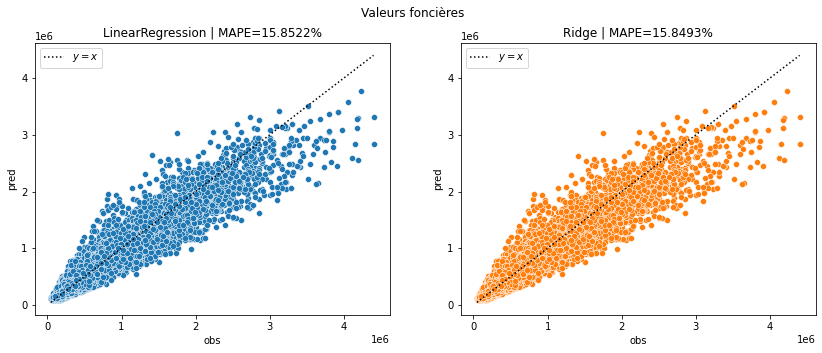

In [86]:
models = ["LinearRegression", "Ridge"]
colors = sns.color_palette(n_colors=2)

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Valeurs foncières")

for model_name, color, ax in zip(models, colors, axes.flatten()): 

    m = sk_results[model_name]["model"]
    y_pred = m.predict(X_te) 

    tmp = pd.DataFrame(data={
        "obs": get_predicted_price(y_te), 
        "pred": get_predicted_price(y_pred)
    })

    min_x, max_x = tmp.obs.min(), tmp.obs.max()

    sns.scatterplot(data=tmp, x="obs", y="pred", color=color, ax=ax)
    sns.lineplot(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        label=r"$y=x$", 
        color="black", 
        linestyle="dotted", 
        ax=ax)

    ax.legend()

    mape = mean_absolute_percentage_error(tmp.obs, tmp.pred)
    ax.set_title(f"{model_name} | MAPE={round(100 * mape, 4)}%"); 

##### Approche `statsmodels`

In [100]:
X_tr_ = pd.DataFrame(data=X_tr, columns=features)
X_tr_ = sm.add_constant(X_tr_, prepend=True)

y_tr_ = pd.DataFrame(data=y_tr, columns=["l_valeur_fonciere"])

mod = sm.OLS(y_tr_, X_tr_)
res = mod.fit()

print(res.summary())

OLS Regression Results                            
==============================================================================
Dep. Variable:      l_valeur_fonciere   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 2.828e+04
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:24:44   Log-Likelihood:                 17003.
No. Observations:              108935   AIC:                        -3.393e+04
Df Residuals:                  108896   BIC:                        -3.355e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
==========================
                                                          coef    std err          t      
P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
--------------------------
const                                                   0.3893      0.116      3.355      
0.001       0.162       0.617
l_valeur_fonciere_ma7                                  -0.0034      0.007     -0.482      
0.630      -0.017       0.010
l_valeur_fonciere_ma14                                  0.0024      0.012      0.208      
0.835      -0.021       0.026
l_valeur_fonciere_ma30                                  0.0152      0.015      0.992      
0.321      -0.015       0.045
l_valeur_fonciere_ma90                                  0.6746      0.015     45.169      
0.000       0.645       0.704
l_surface_reelle_bati                                   0.9344      0.003    274.979      
0.000       0.928       0.941
nombre_pieces_principales_1                            -0.0053      0.016     -0.339      
0.734      -0.036       0.025
nombre_pieces_principales_3                            -0.0728      0.023     -3.197      
0.001      -0.117      -0.028
nombre_pieces_principales_4                            -0.3086      0.038     -8.074      
0.000      -0.384      -0.234
nombre_pieces_principales_5                            -0.4779      0.063     -7.623      
0.000      -0.601      -0.355
nombre_pieces_principales_6-8                           0.0167      0.100      0.167      
0.867      -0.179       0.213
dependance_1                                            0.0171      0.002      9.917      
0.000       0.014       0.020
arrondissement_1                                        0.0577      0.007      8.052      
0.000       0.044       0.072
arrondissement_10                                       0.0387      0.003     11.339      
0.000       0.032       0.045
arrondissement_11                                       0.1078      0.003     34.753      
0.000       0.102       0.114
arrondissement_12                                       0.0323      0.003      9.257      
0.000       0.025       0.039
arrondissement_13                                       0.0297      0.004      7.885      
0.000       0.022       0.037
arrondissement_14                                       0.0565      0.003     16.410      
0.000       0.050       0.063
arrondissement_16                                      -0.2914      0.006    -51.867      
0.000      -0.302      -0.280
arrondissement_17                                      -0.0811      0.003    -25.049      
0.000      -0.087      -0.075
arrondissement_18                                       0.1158      0.004     32.862      
0.000       0.109       0.123
arrondissement_19                                       0.0067      0.004      1.706      
0.088      -0.001       0.014
arrondissement_2                                        0.1144      0.005     21.495      
0.000       0.104       0.125
arrondissemen

#### Arbre de décision - `DecisionTreeRegressor`

Etant donné que l"on dispose d"un grand nombre de variables catégorielles, l"arbre de décision peut être adapté pour prédire le logarithme de la valeur foncière par m². A nouveau, on décide de garder les paramètres par défaut afin de gagner en temps de calcul. L"optimisation de ces hyperparamètres se fera par la suite.

In [512]:
estimator = DecisionTreeRegressor()
model_name = estimator.__class__.__name__

model = CustomRegressor(estimator)

model.fit(X_tr, y_tr)

mae_tr = model.score(X_tr, y_tr, scoring="mae")
mae_te = model.score(X_te, y_te, scoring="mae")

mape_tr = model.score(X_tr, y_tr, scoring="mape")
mape_te = model.score(X_te, y_te, scoring="mape")

mse_tr = model.score(X_tr, y_tr, scoring="mse")
mse_te = model.score(X_te, y_te, scoring="mse")

r2_tr = model.score(X_tr, y_tr, scoring="r2")
r2_te = model.score(X_te, y_te, scoring="r2")

sk_results[model_name] = {
    "model": model, 
    "mae_tr": mae_tr, 
    "mae_te": mae_te, 
    "mape_tr": mape_tr, 
    "mape_te": mape_te, 
    "mse_tr": mse_tr, 
    "mse_te": mse_te, 
    "r2_tr": r2_tr, 
    "r2_te": r2_te
}

In [513]:
make_regression_report(sk_results)

                              Résultats pour l_valeur_fonciere                               
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Model   ┃ MAE     ┃ MAE     ┃ % MAPE  ┃ % MAPE  ┃ MSE      ┃ MSE     ┃ % R²     ┃ % R²    ┃
┃         ┃ train   ┃ test    ┃ train   ┃ test    ┃ train    ┃ test    ┃ train    ┃ test    ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ DummyR… │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Linear… │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Ridge   │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Lasso   │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Elasti… │ 0.54    │ 0.54    │ 4.16    │ 4.1     │ 0.46     │ 0.46    │ 1.68     │ 0.96    │
│ Decisi… │ 0.01    │ 0.23    │ 0.05    │ 1.78    │ 0.0      │ 0.09    │ 99.77    │ 80.53   │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

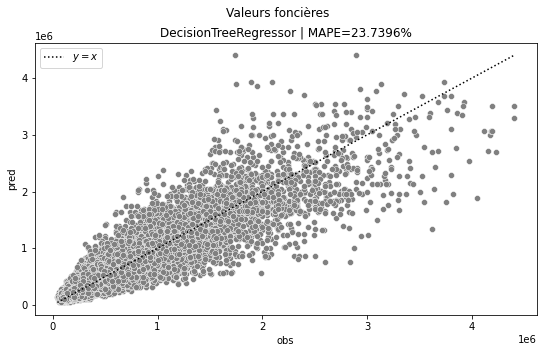

In [518]:
model_name = "DecisionTreeRegressor"

m = sk_results[model_name]["model"]
y_pred = m.predict(X_te) 

tmp = pd.DataFrame(data={
    "obs": get_predicted_price(y_te), 
    "pred": get_predicted_price(y_pred)
})

min_x, max_x = tmp.obs.min(), tmp.obs.max()

fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle("Valeurs foncières")

sns.scatterplot(data=tmp, x="obs", y="pred", color="grey", ax=ax)
sns.lineplot(
    x=[min_x, max_x], 
    y=[min_x, max_x], 
    label=r"$y=x$", 
    color="black", 
    linestyle="dotted", 
    ax=ax)

ax.legend()

mape = mean_absolute_percentage_error(tmp.obs, tmp.pred)
ax.set_title(f"{model_name} | MAPE={round(100 * mape, 4)}%"); 

#### Méthodes ensemblistes

Pour améliorer la qualité de prédiction, on décide d"utiliser des méthodes ensemblistes qui combinent plusieurs arbres de régression :
- `RandomForestRegressor` pour avoir un modèle à faible variance (apprentissage parallèle)
- `GradientBoostingRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)
- `XGBRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)

On commence par entrainer ces 3 modèles sans optimisation des hyper-paramètres. 

In [519]:
estimator = RandomForestRegressor()
model_name = estimator.__class__.__name__

model = CustomRegressor(estimator)

model.fit(X_tr, y_tr)

mae_tr = model.score(X_tr, y_tr, scoring="mae")
mae_te = model.score(X_te, y_te, scoring="mae")

mape_tr = model.score(X_tr, y_tr, scoring="mape")
mape_te = model.score(X_te, y_te, scoring="mape")

mse_tr = model.score(X_tr, y_tr, scoring="mse")
mse_te = model.score(X_te, y_te, scoring="mse")

r2_tr = model.score(X_tr, y_tr, scoring="r2")
r2_te = model.score(X_te, y_te, scoring="r2")

sk_results[model_name] = {
    "model": model, 
    "mae_tr": mae_tr, 
    "mae_te": mae_te, 
    "mape_tr": mape_tr, 
    "mape_te": mape_te, 
    "mse_tr": mse_tr, 
    "mse_te": mse_te, 
    "r2_tr": r2_tr, 
    "r2_te": r2_te
}

In [520]:
make_regression_report(sk_results)

                              Résultats pour l_valeur_fonciere                               
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Model   ┃ MAE     ┃ MAE     ┃ % MAPE  ┃ % MAPE  ┃ MSE      ┃ MSE     ┃ % R²     ┃ % R²    ┃
┃         ┃ train   ┃ test    ┃ train   ┃ test    ┃ train    ┃ test    ┃ train    ┃ test    ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ DummyR… │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Linear… │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Ridge   │ 0.16    │ 0.15    │ 1.22    │ 1.17    │ 0.04     │ 0.04    │ 90.8     │ 91.12   │
│ Lasso   │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Elasti… │ 0.54    │ 0.54    │ 4.16    │ 4.1     │ 0.46     │ 0.46    │ 1.68     │ 0.96    │
│ Decisi… │ 0.01    │ 0.23    │ 0.05    │ 1.78    │ 0.0      │ 0.09    │ 99.77    │ 80.53   │
│ Random… │ 0.06    │ 0.16    │ 0.49    │ 1.22    │ 0.01     │ 0.04    │ 98.44    │ 90.59   │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

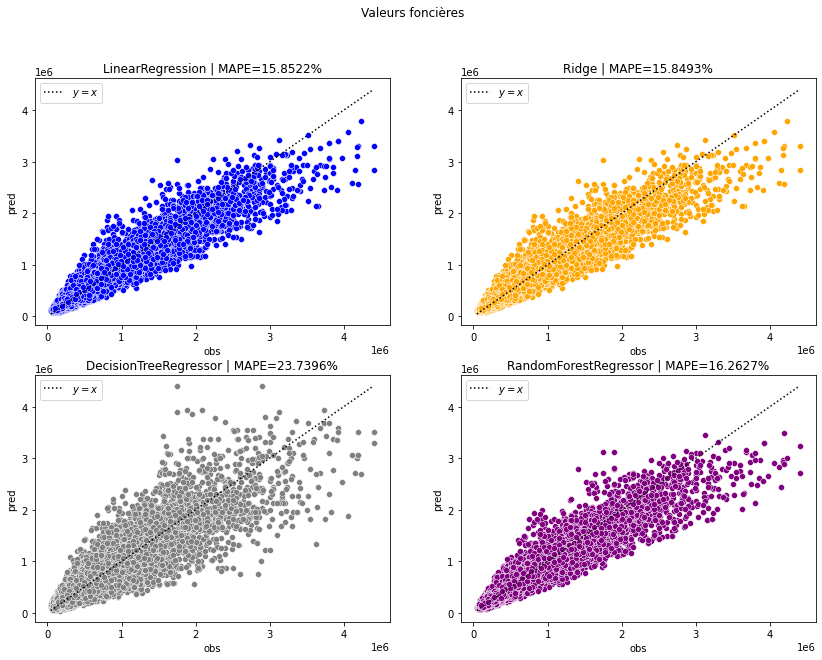

In [521]:
models = ["LinearRegression", "Ridge", "DecisionTreeRegressor", "RandomForestRegressor"]
colors = ["blue", "orange", "gray", "purple"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle("Valeurs foncières")

for model_name, color, ax in zip(models, colors, axes.flatten()): 

    m = sk_results[model_name]["model"]
    y_pred = m.predict(X_te) 

    tmp = pd.DataFrame(data={
        "obs": get_predicted_price(y_te), 
        "pred": get_predicted_price(y_pred)
    })

    min_x, max_x = tmp.obs.min(), tmp.obs.max()

    sns.scatterplot(data=tmp, x="obs", y="pred", color=color, ax=ax)
    sns.lineplot(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        label=r"$y=x$", 
        color="black", 
        linestyle="dotted", 
        ax=ax)

    ax.legend()

    mape = mean_absolute_percentage_error(tmp.obs, tmp.pred)
    ax.set_title(f"{model_name} | MAPE={round(100 * mape, 4)}%"); 

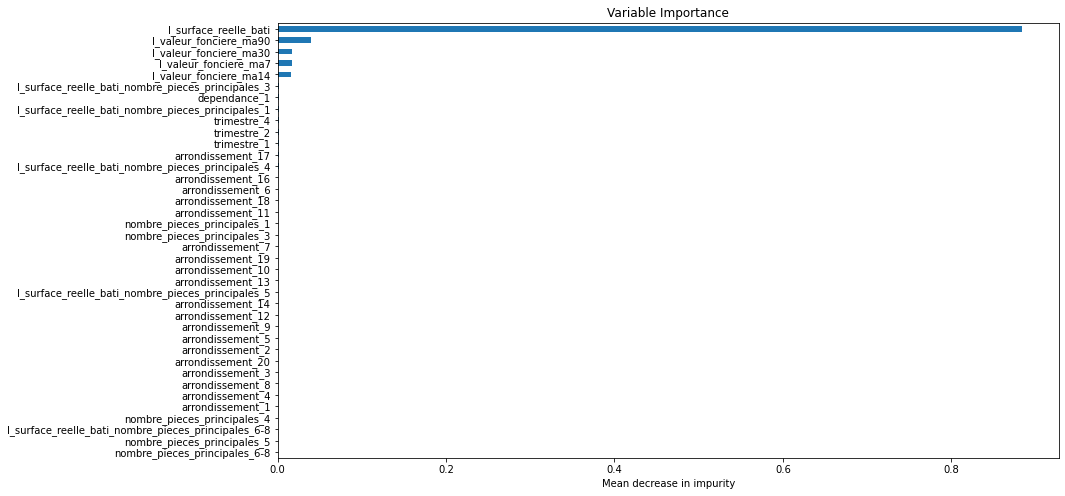

In [524]:
rf = sk_results["RandomForestRegressor"]["model"].estimator

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots(figsize=(14, 8))

forest_importances\
    .sort_values()\
    .plot.barh(yerr=std, align="center", ax=ax)

ax.set_title("Variable Importance")
ax.set_xlabel("Mean decrease in impurity"); 

### Sélection des variables discriminantes

En croisant les résultats des modèles linéaires et les importances des variables en terme de MDG, on décide d'entrainer les modèles en enlevant les dummies d'arrondissement de la matrice des features. On suppose que l'arrondissement est capturé par les variables `l_valeur_fonciere_ma[k]` qui correspondent au logarithme des moyennes mobiles de la valeur foncière moyenne journalière par arrondissement.  

In [77]:
to_keep = [
    ix
    for ix, feature in enumerate(features) 
    if not "arrondissement" in feature
]
features2 = [
    feature
    for feature in features
    if not "arrondissement" in feature
]

X_tr2 = X_tr[:, to_keep]
X_te2 = X_te[:, to_keep]

In [111]:
help(SVR)

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies th

In [78]:
sk_results2 = {} 

estimators = [
    DummyRegressor(), 
    LinearRegression(), 
    Ridge(), 
    # KNeighborsRegressor(), 
    # SVR(),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),  
    GradientBoostingRegressor()
]

loop = tqdm(estimators)

for estimator in loop:

    model = CustomRegressor(estimator)
    model_name = estimator.__class__.__name__

    model.fit(X_tr2, y_tr)

    mae_tr = model.score(X_tr2, y_tr, scoring="mae")
    mae_te = model.score(X_te2, y_te, scoring="mae")

    mape_tr = model.score(X_tr2, y_tr, scoring="mape")
    mape_te = model.score(X_te2, y_te, scoring="mape")

    mse_tr = model.score(X_tr2, y_tr, scoring="mse")
    mse_te = model.score(X_te2, y_te, scoring="mse")

    r2_tr = model.score(X_tr2, y_tr, scoring="r2")
    r2_te = model.score(X_te2, y_te, scoring="r2")

    loop.set_description(f"{model_name} | Test MAPE={round(100*mape_te, 2)}%")

    sk_results2[model_name] = {
        "model": model, 
        "mae_tr": mae_tr, 
        "mae_te": mae_te, 
        "mape_tr": mape_tr, 
        "mape_te": mape_te, 
        "mse_tr": mse_tr, 
        "mse_te": mse_te, 
        "r2_tr": r2_tr, 
        "r2_te": r2_te
    }

GradientBoostingRegressor | Test MAPE=1.2%: 100%|██████████| 6/6 [04:46<00:00, 47.67s/it]


In [79]:
make_regression_report(sk_results2)

                              Résultats pour l_valeur_fonciere                               
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Model   ┃ MAE     ┃ MAE     ┃ % MAPE  ┃ % MAPE  ┃ MSE      ┃ MSE     ┃ % R²     ┃ % R²    ┃
┃         ┃ train   ┃ test    ┃ train   ┃ test    ┃ train    ┃ test    ┃ train    ┃ test    ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ DummyR… │ 0.54    │ 0.54    │ 4.19    │ 4.14    │ 0.47     │ 0.47    │ 0.0      │ -0.72   │
│ Linear… │ 0.17    │ 0.16    │ 1.29    │ 1.23    │ 0.05     │ 0.04    │ 89.88    │ 90.49   │
│ Ridge   │ 0.17    │ 0.16    │ 1.29    │ 1.23    │ 0.05     │ 0.04    │ 89.88    │ 90.49   │
│ Decisi… │ 0.01    │ 0.24    │ 0.05    │ 1.82    │ 0.0      │ 0.09    │ 99.77    │ 79.88   │
│ Random… │ 0.07    │ 0.16    │ 0.5     │ 1.26    │ 0.01     │ 0.05    │ 98.38    │ 90.06   │
│ Gradie… │ 0.16    │ 0.16    │ 1.25    │ 1.2     │ 0.04     │ 0.04    │ 90.43    │ 90.78   │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

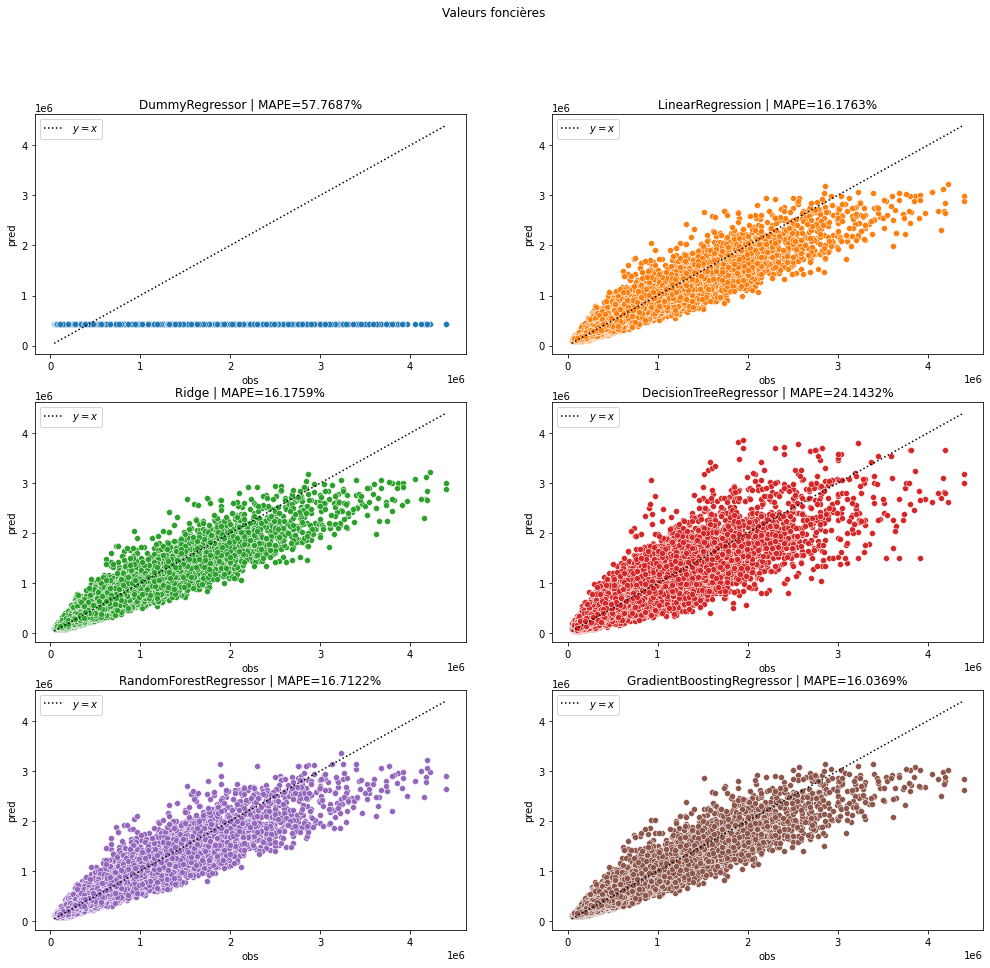

In [84]:
colors = sns.color_palette(n_colors=6)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17, 15))
fig.suptitle("Valeurs foncières")

for (model_name, results_), color, ax in zip(sk_results2.items(), colors, axes.flatten()): 

    m = results_["model"]
    y_pred = m.predict(X_te2) 

    tmp = pd.DataFrame(data={
        "obs": get_predicted_price(y_te), 
        "pred": get_predicted_price(y_pred)
    })

    min_x, max_x = tmp.obs.min(), tmp.obs.max()

    sns.scatterplot(data=tmp, x="obs", y="pred", color=color, ax=ax)
    sns.lineplot(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        label=r"$y=x$", 
        color="black", 
        linestyle="dotted", 
        ax=ax)

    ax.legend()

    mape = mean_absolute_percentage_error(tmp.obs, tmp.pred)
    ax.set_title(f"{model_name} | MAPE={round(100 * mape, 4)}%"); 

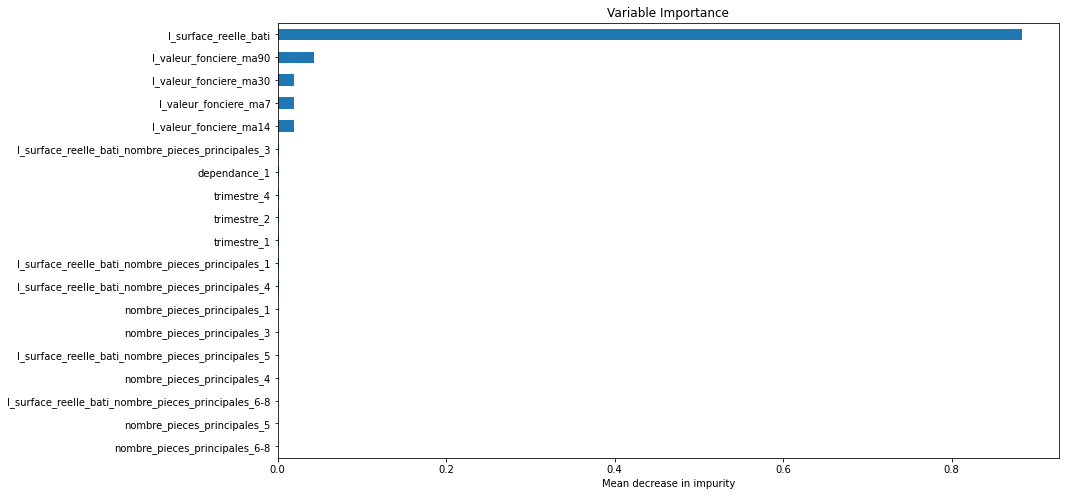

In [91]:
rf = sk_results2["RandomForestRegressor"]["model"]

importances = rf.estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimator.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features2)

fig, ax = plt.subplots(figsize=(14, 8))

forest_importances\
    .sort_values()\
    .plot.barh(yerr=std, align="center", ax=ax)

ax.set_title("Variable Importance")
ax.set_xlabel("Mean decrease in impurity"); 

### Optimisation via `optuna`

In [55]:
def objective_xgb(trial: Trial, target: str) -> float:
    """Description. Objective function for XGBRegressor optimization with optuna.
    
    Returns: (float) test MAPE."""

    return NotImplementedError